In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import  permutation_test
from scipy.stats import rankdata
from scipy.stats import norm
from copy import deepcopy
# paths
datos_g10_path = "https://raw.githubusercontent.com/apolineo11/PYEF/main/Cuadernos/Data/Datos_Probabilidad_Grupo_10.xlsx"
datos_g11_path = "https://raw.githubusercontent.com/apolineo11/PYEF/main/Cuadernos/Data/Datos_Probabilidad_Grupo_11.xlsx"

In [2]:
# leer los datos
datos_g10 = pd.read_excel(datos_g10_path)
datos_g11 = pd.read_excel(datos_g11_path, skiprows=1)

In [3]:
# limpieza datos
datos_g10.rename(columns={"ESTRATO DEL PREDIO DONDE VIVE":"ESTRATO",
                          "EDAD (AÑOS)":"EDAD",
                          "PROGRAMA ACADÉMICO":"PROGRAMA",
                          "NÚMERO DE MATRICULAS": "MATRICULAS",
                          "ESTATURA (CM)": "ESTATURA",
                          "PESO (KG)": "PESO"}, inplace=True)
datos_g11.rename(columns={"ESTRATO DEL PREDIO DONDE VIVE ":"ESTRATO",
                          "EDAD (AÑOS)":"EDAD",
                          "PROGRAMA ACADEMICO":"PROGRAMA",
                          "NUMERO DE MATRICULAS": "MATRICULAS",
                          "ESTATURA (CM)": "ESTATURA",
                          "PESO KG)": "PESO"}, inplace=True)
columns_df = ["ESTRATO", "EDAD", "PROGRAMA", "MATRICULAS", "ESTATURA", "PESO"]
datos_g10 = datos_g10[columns_df]
datos_g11 = datos_g11[columns_df]
df = pd.concat([datos_g10, datos_g11])
programa_dict = {"ADMINISTRACIÓN": "ADMINISTRACION", "ECONOMÍA":"ECONOMIA", "CONTADURÍA PÚBLICA":"CONTADURIA PUBLICA"}
df.replace({"PROGRAMA": programa_dict}, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.astype({"EDAD": "int32", "MATRICULAS":"int32", "ESTRATO":"int32", "PROGRAMA":"category"})
df["ESTRATO"] = df["ESTRATO"].astype("str").astype("category")
df["ESTRATO"] = df["ESTRATO"].cat.reorder_categories(["1", "2", "3", "4", "5", "6"], ordered=True)


In [4]:
df.head()

,ESTRATO,EDAD,PROGRAMA,MATRICULAS,ESTATURA,PESO
0,1,24,ADMINISTRACION,6,175.0,67.0
1,3,25,ADMINISTRACION,4,145.0,60.0
2,5,18,ECONOMIA,3,185.0,87.0
3,3,20,ECONOMIA,3,173.0,57.0
4,5,17,ADMINISTRACION,3,160.0,58.0


# Coeficiente de correlación $\rho$ de Spearman

Es una medida no paramétrica de correlación que evalúa la fuerza y dirección de una asociación **monótona** entre dos variables (*ordinales*), a partir de sus rangos. Se utiliza cuando los datos no cumplen los supuestos de normalidad o relación lineal requeridos por la correlación de Pearson.


---

## Monotonía

Si en dos conjuntos $A$ y $B$ existe una relación de tal forma que a un elemento de $A$ le corresponde un elemento de $B$, de tal manera que tenemos pares ordenados
$(a_k, b_k)$ donde $a_k \in A$ y $b_k \in B$.

- **Monotonía Creciente**:
$$a_i \leq a_j \Rightarrow b_i \leq b_j$$ 

- **Monotonía Decreciente**:
$$a_i \leq a_j \Rightarrow b_i \geq b_j$$

---

## Cálculo

Suponga que tiene un conjunto de datos de $n$ observaciones, en donde tiene a su vez medidas las variables $X$ y $Y$, entonces:

- El *k-esimo* individuo tiene un par de datos asociados: $(X_k = x_k, Y_k= y_k)$, donde $1 \leq k \leq n$.
- Tanto las variables $X$ y $Y$ son de naturaleza ordinal. Con ello podemos calcular la función $\operatorname{rank}(X) = R_X$ y $\operatorname{rank}(Y) = R_Y$. Esta función asigna un número entre $1$ y $n$ que refleja la posición que ocupa cada elemento cuando se ordena todo el vector de observaciones en forma ascendente.
- De tal forma que ahora tenemos dos nuevos vectores de observaciones $R_X$ y $R_Y$

$$\rho_s(X,Y) = \frac{\operatorname{Cov}(R_X, R_Y)}{\sigma_{R_X} \sigma_{R_Y}}$$


Es evidente que $\rho_s$ es el mismo coeficiente de correlación de *Pearson* pero aplicado a las nuevas variables. Entonces, lo que mide es el grado de asociación lineal entre las variables $\operatorname{rank}(X)$ y $\operatorname{rank}(Y)$, esto redunda en medir una asociación monótona entre las variables $X$ y $Y$.


---
**Nota**: Cuando hay empates en el cálculo del ranking, se procede a desempatar con el promedio de dicho ranking.









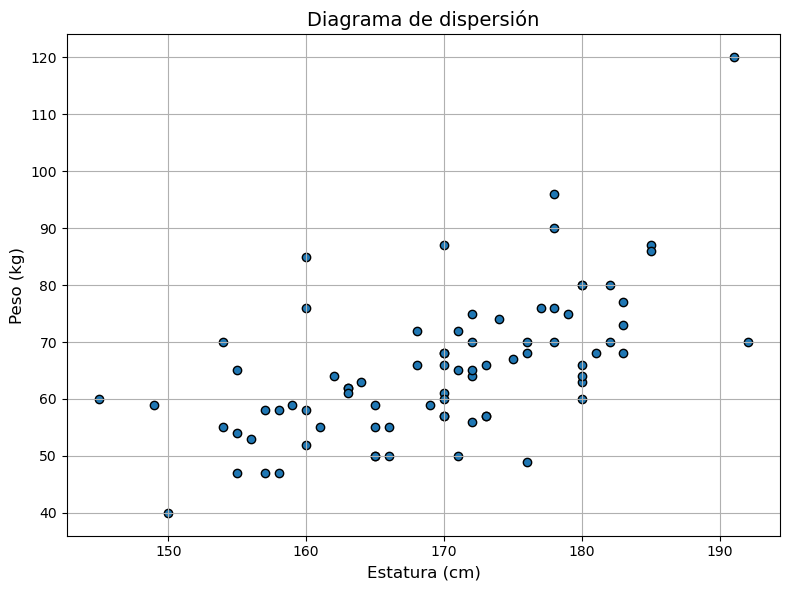

In [5]:
##############
# Dispersión #
##############

# scatter plot peso vs estatura
plt.figure(figsize=(8, 6))

# Crear scatter plot
plt.scatter(x=df["ESTATURA"], y=df["PESO"], edgecolors='k')

# Crear la linea de regresón
# Personalización
plt.title('Diagrama de dispersión', fontsize=14)
plt.xlabel('Estatura (cm)', fontsize=12)
plt.ylabel('Peso (kg)', fontsize=12)
plt.grid(True)

# Mostrar gráfico
plt.tight_layout()
plt.show()

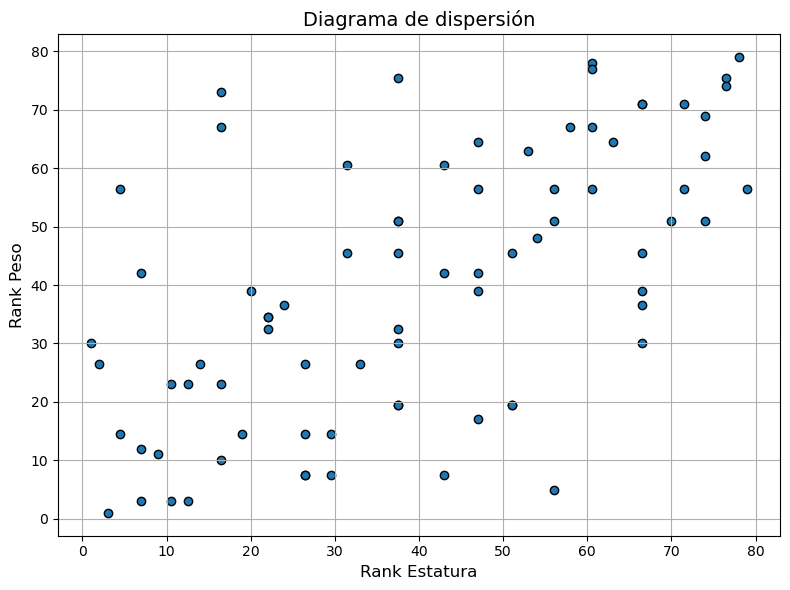

In [6]:
# calculo de ranking
df['rank_ESTATURA'] = df['ESTATURA'].rank(method='average')
df['rank_PESO'] = df['PESO'].rank(method='average')

# scatter plot rank_peso vs rank_estatura
plt.figure(figsize=(8, 6))

# Crear scatter plot
plt.scatter(x=df["rank_ESTATURA"], y=df["rank_PESO"], edgecolors='k')

# Crear la linea de regresón
# Personalización
plt.title('Diagrama de dispersión', fontsize=14)
plt.xlabel('Rank Estatura', fontsize=12)
plt.ylabel('Rank Peso', fontsize=12)
plt.grid(True)

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [7]:
# cálculo
pho, p_value = spearmanr(df['PESO'], df['ESTATURA'])
print(f"El coeficiente de correlación de spearman es de: '{pho:.3f}'")

El coeficiente de correlación de spearman es de: '0.612'


## Significancia estadística

Una vez calculado el $\rho_s$ se debe ver si dicho valor es estadísticamente significante, para ello se usan dos aproximaciones. Una desde las permutaciones y otra de forma asintótica. Sin importar cual aproximación se usa, el supuesto primordial es asumir que nuestros datos son independientes. Con ello, probamos que tan probable es observar un $\rho_s$ como el que nuestros datos arrojan.

---

### Sistema de Hipótesis

El objetivo es evaluar si existe una asociación monótona entre las variables $X$ y $Y$.

### Bilateral

- $H_0$: $\rho_s = 0$
- $H_1$: $\rho \neq 0$

### Unilateral

- $H_0$: $\rho_s = 0$
- $H_1$: $\rho_s > 0$ o $H_1$: $\rho_s < 0$


---

### Permutaciones (Bilateral)

Este enfoque se tiene lo siguiente:

- Calcular los *rankings* de las variables $X$ y $Y$
- Tomamos el vector $\operatorname{rank}(X)$ como un vector fijo.
- Para cada posible permutación del vector $\operatorname{rank}(Y)$ calculamos el coeficiente de correlacion de *Pearson*. Esto lo que hace es emparejar a cada componente del vector $\operatorname{rank}(X)$ una nueva componente resultado de la permutación (cambio de orden) del vector $\operatorname{rank}(Y)$.
- Se cuenta cuantos de los $n!$ posibles $|\rho_s^{(b)}|$ son mayores al que nuestros datos generaron $|\rho_s^{(obs)}|$. Esta frecuencia relativa al total nos da la probabilidad y con un nivel $\alpha$ podriamos determinar su significancia:

$$\operatorname{pvalue}(\rho_s) = \frac{\#\left\{b:|\rho_s^{(b)}| > |\rho_s^{(obs)}|\right\}}{n!}$$

Sin embargo, a medida que $n$ se hace muy grande, computacionalmente es inviable hacer $n!$ permutaciones. Se prefiere hacer un número $B$ considerable de permutaciones aleatorias. Además, también se hace una corrección que tiene en cuenta que el conjunto no tenga ningún elemento. Es decir, si en las $B$ permutaciones no existe ningún valor mayor al de nuestros datos, por ende:

$$\operatorname{pvalue}(\rho_s) = \frac{ 1 + \#\left\{b:|\rho_s^{(b)}| > |\rho_s^{(obs)}|\right\}}{1 + B}$$


**NOTA**: Se considera recomendable este enfoque cuando el tamaño de la muestra es pequeño $n \leq 30$, pero no es limitante ya que si se logra hacer el total de permutaciones posibles su valor es exacto.

In [8]:
# Permutaciones
x = deepcopy(df['ESTATURA'])
y = deepcopy(df['PESO'])

def statistic(x):
    return spearmanr(x, y).statistic

res_exact = permutation_test((x,), statistic, permutation_type='pairings')
print(f"El valor p del estadístico calculado por permutaciones es de: '{res_exact.pvalue:.3E}'")


El valor p del estadístico calculado por permutaciones es de: '2.000E-04'


### Asintótica

Existen 2 aproximaciones asintóticas:


Cuando $n$ es suficientemente grande, $\rho_s$ es asintóticamente normal.

##### **Sin empates:**

$$
Z = \rho_s \cdot \sqrt{n - 1} \sim \mathcal{N}(0,1)
$$

##### **Con empates:**

Se corrige la varianza:

$$
\text{Var}(\rho_s) = \frac{1 - e_x - e_y}{n - 1}
\quad \Rightarrow \quad
Z = \frac{\rho_s}{\sqrt{\text{Var}(\rho_s)}} \sim \mathcal{N}(0,1)
$$

donde:

$$
e = \frac{1}{n(n^2 - 1)} \sum_j (t_j^3 - t_j)
\quad \text{(para grupos empatados de tamaño } t_j)
$$


In [9]:
# Funciones para calcular la varianza corregida y la signmificancia
def correction_term(x):
    """
    Calcula el termino e_x de correccion por empate
    """
    rank_x = rankdata(x, method='average')
    n = len(x)
    _, size_rank = np.unique(rank_x,return_counts=True)
    tie_x = size_rank[size_rank>1]
    e = ((np.sum(tie_x**3 - tie_x))/(n*(n**2 - 1))) if len(tie_x) > 0 else 0.0
    return e

def corrected_var(x,y):
    """
    Calcula la varianza corregida de rho
    """
    e_x = correction_term(x)
    e_y = correction_term(y)
    n = len(x)
    var = (1- e_x - e_y)/(n-1)
    return var

# Calculo del estadístico Z

def z_spearman(x,y):
    """
    Calcula el estadístico z
    """
    rho_s = spearmanr(x, y).statistic
    var = corrected_var(x,y)
    z = rho_s/np.sqrt(var)
    return z

def p_value_spearman(z, h1="bilateral"):
    """
    Calcula el p valor
    """

    if h1.lower()=="bilateral":
        p_value = 2*norm.sf(np.abs(z))
        return p_value
    elif h1.lower()=="greater":
        p_value = norm.sf(z)
        return p_value
    elif h1.lower()=="less":
        p_value = norm.cdf(z)
        return p_value
    else:
        raise ValueError

# calculo del p value con aproximación normal
z_rho = z_spearman(df['ESTATURA'], df['PESO'])
p_value_z = p_value_spearman(z_rho)
print(f"El estadístico de prueba Z con aproximación normal es: '{z_rho:.3f}' -- Tiene un p-valor de: '{p_value_z:.3E}'")

El estadístico de prueba Z con aproximación normal es: '5.412' -- Tiene un p-valor de: '6.229E-08'




#### **T-Student**

Bajo ciertos supuestos se puede asumir que:

$$t = \frac{\rho_s \sqrt{n-2}}{\sqrt{1-\rho_s^2}} \sim t_{n-2}$$

In [10]:
# calculo con aproximación t-student
n = len(df)
rho_s, p_value_t = spearmanr(df["ESTATURA"], df["PESO"])
t = rho_s*(np.sqrt(n-2))/(np.sqrt(1-rho_s**2))
print(f"El estadístico de prueba t por aproximación t-student es: '{t:.3f}' -- Tiene un p-valor de: '{p_value_t:.3E}'")


El estadístico de prueba t por aproximación t-student es: '6.782' -- Tiene un p-valor de: '2.142E-09'
